In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
import time
import json
import pandas as pd
import requests
from pandas import json_normalize
import os
import csv
pd.options.mode.chained_assignment = None
import seaborn as sns
import scikitplot as skplt
import scipy  
from scipy.cluster import hierarchy as hc
from collections import defaultdict
from rfpimp import *

# Machine learning
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
 
from imblearn.over_sampling import SMOTENC


from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification


from dtreeviz.trees import *
 
# Then run the code below if you get an error telling you that graphviz isn't in your system path (Windows users)
# https://stackoverflow.com/a/44625895
import os
your_graphviz_install_directory = 'C:/Users/bosem/anaconda3/Library/bin/graphviz'
os.environ["PATH"] += os.pathsep + your_graphviz_install_directory

C:\Users\bosem\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
passes = pd.read_csv('Passesfrom11seasons.csv')
passes['location'] = passes['location'].astype(str).str.strip('[]')
passes['y_loc'] = passes['location'].str.split(', ').str.get(0).str.strip().astype(float)
passes['x_loc'] = passes['location'].str.split(', ').str.get(1).str.strip().astype(float)
passes['pass_end_location'] = passes['pass_end_location'].astype(str).str.strip('[]')
passes['end_y_loc'] = passes['pass_end_location'].str.split(', ').str.get(0).str.strip().astype(float)
passes['end_x_loc'] = passes['pass_end_location'].str.split(', ').str.get(1).str.strip().astype(float)
# Reset index
passes = passes.reset_index().drop('level_0', axis=1)
# Create succes column
passes.loc[passes['pass_outcome_name'].isnull(),'success'] = 1
passes.loc[passes['pass_outcome_name'].notnull(), 'success'] = 0
passes['x_dist'] = passes['end_x_loc'] - passes['x_loc'] + 1e-5
passes['y_dist'] = passes['end_y_loc'] - passes['y_loc']
passes['distance'] = np.sqrt((passes['x_dist']**2 + passes['y_dist']**2))
passes['angle'] = np.abs(np.arctan2(passes['y_dist'],passes['x_dist']))
feature_cols = ['duration', 'angle', 'pass_body_part_name', 'x_loc', 'y_loc', 'end_x_loc','end_y_loc',
                'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_height_name', 'distance', 
                'pass_switch', 'pass_through_ball', 'play_pattern_name', 'under_pressure', 'success']
pass_final = passes[feature_cols]
bool_cols = ['pass_cross', 'pass_cut_back', 'pass_deflected','pass_switch', 'pass_through_ball','under_pressure']
for col in bool_cols:
    pass_final[col] = np.where(pass_final[col].isna(), 0, 1)
features = pass_final.drop('success', axis=1)
labels = pass_final['success']

C:\Users\bosem\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (41,122) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cont_cols = ['duration', 'angle', 'distance','x_loc', 'y_loc', 'end_x_loc','end_y_loc'] 
cat_features = features.drop(cont_cols, axis=1)
cont_features = features[cont_cols]
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head(20).transpose())
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings
cat_features_le, mappings = label_encode(cat_features)
features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)

In [4]:
X = features_le
y = labels
 
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=y, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1
 
loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.06524


In [5]:
# from numpy.random import rand
# from numpy.random import seed
# seed(42)
# copyX = X + rand(*X.shape) / 100000.0
# def dendrogram(X):
#     corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
#     corr_condensed = hc.distance.squareform(1-corr)
#     z = hc.linkage(corr_condensed, method='average')
#     fig = plt.figure(figsize=(10,8))
#     dendrogram = hc.dendrogram(z, labels=X.columns, 
#           orientation='right', leaf_font_size=16)
#     plt.show()
#     return
# dendrogram(copyX)

In [6]:
# feats = ['x_loc', 'end_x_loc',
#          'y_loc', 'end_y_loc',
#          'distance', 'duration']
# print('original', "{0:.5f}".format(loss))
# for feat in feats:
#     loss_feats = get_loss(X=X.drop(feat, axis=1))   
#     print(feat, "{0:.5f}".format(loss_feats))

In [7]:
# Define a function to get feature importance using the drop-column method
# def get_imp(X, y=y, m=m, cv=cv):
#     baseline = get_loss(X=X, y=y, m=m, cv=cv)
#     imp = []
#     for col in X.columns:
#         s = get_loss(X=X.drop(col, axis=1), y=y, m=m, cv=cv)
#         change_in_score = s - baseline
#         imp.append(change_in_score)
#     imp_df = pd.DataFrame(data={'Feature': X.columns, 'Importance': np.array(imp)})
#     imp_df = imp_df.set_index('Feature').sort_values('Importance', ascending=False)
#     return imp_df

# imp1 = get_imp(X=X)
# imp1.reset_index().plot('Feature', 'Importance', figsize=(10,6), legend=False);

In [8]:
# plot_importances(imp1, imp_range=(min(imp1.values), max(imp1.values)))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

In [10]:
# Define a function to create n_estimators vs Brier loss plots for different hyperparameters
# Modified from https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# from collections import OrderedDict

# def plot_loss(model_list, min_estimators=10, max_estimators=200):
#     # Map a classifier name to a list of (n_estimators, Brier loss) pairs
#     loss_rate = OrderedDict((clf_name, []) for clf_name, _ in model_list)

#     # Range of 'n_estimators' values to explore
#     min_estimators = min_estimators
#     max_estimators = max_estimators

#     for clf_name, clf in model_list:
#         for i in range(min_estimators, max_estimators + 1):
#             clf.set_params(n_estimators=i)
#             clf.fit(X_train, y_train)

#             # Record the Brier loss for each 'n_estimators=i' setting
#             y_pred = clf.predict(X_test)
#             y_pred_proba = clf.predict_proba(X_test)
#             brier = brier_score_loss(y_test, y_pred_proba[:,1])
#             loss_rate[clf_name].append((i, brier))
    
#     # Generate the plot
#     plt.figure(figsize=(12,8))
    
#     for clf_name, clf_err in loss_rate.items():
#         xs, ys = zip(*clf_err)
#         plt.plot(xs, ys, label=clf_name)

#     plt.xlim(min_estimators, max_estimators)
#     plt.xlabel("n_estimators")
#     plt.ylabel("Brier loss")
#     plt.legend(loc="upper right");
#     return

In [11]:
# Setting warm_start=True is necessary for tracking the loss rate during training for different values of n_estimators
# max_features = [
#     ("RandomForestClassifier, max_features='sqrt'",
#         RandomForestClassifier(n_estimators=100, warm_start=True, max_features='sqrt', random_state=42)),
#     ("RandomForestClassifier, max_features=0.5",
#         RandomForestClassifier(n_estimators=100, warm_start=True, max_features=0.5, random_state=42)),
#     ("RandomForestClassifier, max_features=None",
#         RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, random_state=42)),
# ]

# # Note that 'log2' is another commonly used value of max_features, but in this case it's essentially the same as 'sqrt'
# plot_loss(max_features)

In [12]:
#  Fit base model to use for comparison
# m = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=42)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(m, X_train, y_train, cv=cv, scoring='brier_score_loss')
# print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

In [13]:
# Create the parameter grid
# params = {
#     'min_samples_leaf': [3, 4, 5, 6, 7],
#     'max_depth': [7, 8, 9, 10, 11]
# }

# # Create the grid search model
# gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
#                   scoring='brier_score_loss', return_train_score=True)

# # Fit gs
# gs.fit(X_train, y_train)

# # Define function to print the results of the grid search
# def print_gs_results(gs, print_all=True):
#     if print_all == True:
#         print('Grid scores:')
#         means = gs.cv_results_['mean_test_score']*-1
#         stds = gs.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, gs.cv_results_['params']):
#             print("%0.5f (+/-%0.05f) for %r"
#                   % (mean, std * 2, params))
#         print()
#         print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
#     else:
#         print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
#     return

In [14]:
# print_gs_results(gs=gs)

In [15]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.06331


In [16]:
# Create the parameter grid
# from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
# params = {
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=9)],
#     'max_depth': [i for i in range(3, 10)],
#     'min_child_weight': [i for i in range(1, 7)],
#     'subsample': [i/10.0 for i in range(6,11)],
#     'colsample_bytree': [i/10.0 for i in range(6,11)]
# }

# # Create the randomised grid search model
# # See http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html
# # "n_iter = number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution"
# rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
#                          scoring='brier_score_loss', return_train_score=True)

# # Fit rgs
# rgs.fit(X_train, y_train)

# # Print results
# print_gs_results(gs=rgs, print_all=False)

In [17]:
# Define a function to help fit models and print the results
def print_results(xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Fit model
    xgb.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    # Print results
    print('Actual passes:', sum(y_test))
    print('Predicted passes (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))
    return

# Evaluate best models on the hold-out set
# best_xgb = rgs.best_estimator_

print_results(xgb=xgb)

Actual passes: 33385.0
Predicted passes (xgb): 33391.86
Brier loss (xgb): 0.06395


In [18]:
# calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')

# print_results(xgb=calibrated_xgb)

In [23]:
import pickle
filename = 'final_model2.sav'
pickle.dump(xgb, open(filename, 'wb'))

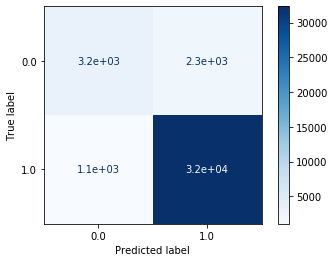

In [21]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(xgb, X_test, y_test,
                                 cmap=plt.cm.Blues)